# Import des librairies

In [1]:
import pandas as pd 
from IPython.display import clear_output
import requests
from bs4 import BeautifulSoup
import urllib
from urllib.request import Request, urlopen
import re
import csv
import numpy as np
import re
from tqdm import tqdm
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from concurrent import futures
import dateparser
import operator
import Levenshtein as lev
import random

#Matplotlib and Seaborn parameters : 
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,8 #Taille de la figure affichée
sns.set_style("darkgrid")#style de l'arrière plan de seaborn 
sns.set_palette("pastel")#Couleurs utilisées dans les graphiques

import warnings
warnings.filterwarnings('ignore')

data_path="Data/"#Chemin du dossier pour enregistrer le fichier csv

In [2]:
def check_nan(df):
    for i in df.columns.tolist():
        print("Valeurs nan dans "+str(i)+" : "+str(df[i].isna().sum()))
        
def check_unique(df):
    for i in df.columns.tolist():
        print("Valeurs uniques dans "+str(i)+" : "+str(df[i].nunique()))

# Chargement des données déjà existantes

In [3]:
df_home = pd.read_csv(data_path+"allocine_home_cleaned.csv")
df_cast= pd.read_csv(data_path+"allocine_casting_movies.csv")
df_name_people=pd.read_csv(data_path+"allocine_id_people.csv") 
df_home.head(2)

,id,titre,date_sortie,support,duree,genres,synopsis,note_moyenne_presse,note_moyenne_spectateurs
0,178014,avatar : la voie de l'eau,2022-12-14,en salle,192.0,"['Science fiction', 'Aventure', 'Fantastique',...",Se déroulant plus d’une décennie après les évé...,"4,1","4,3"
1,281293,les banshees d'inisherin,2022-12-28,en salle,114.0,['Drame'],Sur Inisherin - une île isolée au large de la ...,"3,8","3,9"


## Mise en forme des données existantes

### Conversion des strings représentants des listes en listes

In [4]:
def convert_string_list(df, columns) : 
    for col in columns : 
        df[col] = df[col].apply(lambda list_ids : eval(list_ids) if list_ids!="nan" else np.nan)
    return df 

In [5]:
df_cast["realisateurs"]= df_cast["realisateurs"].astype(str)
df_cast["scenaristes"] = df_cast["scenaristes"].astype(str)
df_cast["acteurs"] = df_cast["acteurs"].astype(str)
df_cast= convert_string_list(df_cast, ["realisateurs","scenaristes","acteurs"])

### On remplace les ids par les vrais noms 

In [6]:
%%time 
df_name_people["id"] = df_name_people["id"].astype(str)
dict_id_name = df_name_people.set_index("id")["nom"].to_dict()
for col in df_cast.set_index("movie_id").columns : 
    df_cast[col]= df_cast[col].apply(lambda list_ids : operator.itemgetter(*list_ids)(dict_id_name) if type(list_ids)!=float else [] )
df_cast.head()

CPU times: total: 156 ms
Wall time: 153 ms


,movie_id,realisateurs,scenaristes,acteurs
0,178014,James Cameron,"(Amanda Silver, James Cameron, James Cameron, ...","(Sam Worthington, Zoe Saldana, Sigourney Weave..."
1,281293,Martin McDonagh,Martin McDonagh,"(Colin Farrell, Brendan Gleeson, Kerry Condon,..."
2,289305,Christian Duguay,"(Lilou Fogli, Christophe Donner, Lilou Fogli, ...","(Mélanie Laurent, Pio Marmaï, Kacey Mottet Kle..."
3,266320,Gerard Johnstone,"(Akela Cooper, Akela Cooper, James Wan)","(Allison Williams, Violet McGraw, Ronny Chieng..."
4,288544,Olivier Treiner,"(Olivier Treiner, Camille Treiner)","(Lou de Laâge, Raphaël Personnaz, Isabelle Car..."


### Jointure df_home et df_cast 

In [7]:
df_data=pd.merge(df_home,df_cast, left_on="id", right_on="movie_id")[["movie_id","titre","date_sortie","realisateurs",
                                                              "scenaristes","acteurs"]]

df_data["release_year"]= pd.to_datetime(df_data["date_sortie"]).dt.year
df_data["acteurs"] = df_data["acteurs"].apply(lambda list_actors : [list_actors] if type(list_actors) == str else list(list_actors))
df_data.head()

,movie_id,titre,date_sortie,realisateurs,scenaristes,acteurs,release_year
0,178014,avatar : la voie de l'eau,2022-12-14,James Cameron,"(Amanda Silver, James Cameron, James Cameron, ...","[Sam Worthington, Zoe Saldana, Sigourney Weave...",2022
1,281293,les banshees d'inisherin,2022-12-28,Martin McDonagh,Martin McDonagh,"[Colin Farrell, Brendan Gleeson, Kerry Condon,...",2022
2,289305,tempête,2022-12-21,Christian Duguay,"(Lilou Fogli, Christophe Donner, Lilou Fogli, ...","[Mélanie Laurent, Pio Marmaï, Kacey Mottet Kle...",2022
3,266320,m3gan,2022-12-28,Gerard Johnstone,"(Akela Cooper, Akela Cooper, James Wan)","[Allison Williams, Violet McGraw, Ronny Chieng...",2022
4,288544,le tourbillon de la vie,2022-12-21,Olivier Treiner,"(Olivier Treiner, Camille Treiner)","[Lou de Laâge, Raphaël Personnaz, Isabelle Car...",2022


# Scrapping des données du box office IMDB

## Fonctions : 

In [8]:
def init_movies_by_driver(nb_drivers, len_data) :
    drivers_ids_range ={}
    nb_films_by_driver = np.ceil(len_data/nb_drivers)
    for i in range(nb_drivers) :
        drivers_ids_range[i]=  {"start" : int(i * nb_films_by_driver), "end" : int((i+1)*nb_films_by_driver)}
    return drivers_ids_range 

In [9]:
def init_save_files_ids(number) :
    for i in range(number) :
        df_init= pd.DataFrame(columns= ['id_searched_movie', 'titre', 'id', 'year', 'actors', 'score_title','score_year', 'score_actors','score_mean'])
        df_init.to_csv(data_path+f"IMDB_matching/{i}.csv",index=False)

In [10]:
def init_save_files_box_office(number) :
    for i in range(number) :
        df_init= pd.DataFrame(columns= ['id_searched_movie', 'titre', 'id', 'year', 'actors', 'score_title','score_year', 'score_actors','score_mean'])
        df_init.to_csv(data_path+f"IMDB_box_office/{i}.csv",index=False)

In [11]:
def workload_threads(params) : 
    df_to_process = df_data.iloc[params["index_start"]:params["index_end"]]
    new_data = []
    
    for i in range(len(df_to_process)) : 
        new_data+= get_best_matching_imdb(df_to_process["movie_id"].iloc[i],df_to_process["titre"].iloc[i], df_to_process["acteurs"].iloc[i],df_to_process["release_year"].iloc[i] )
        if i % 20 == 0 : 
            if params["id"]==0 : 
                clear_output()
            print(f"Threads n°{params['id']} : {i} films sur {len(df_to_process)}")
        time.sleep(random.randint(5,10)/10)
    
    #Sauvegarde des données : 
    df= pd.DataFrame(new_data)
    temp = pd.read_csv(data_path+f"IMDB_matching/{params['id']}.csv")
    pd.concat([temp,df]).to_csv(data_path+f"IMDB_matching/{params['id']}.csv",index=False)

## Récupération des ids
(nécessaires pour accéder à la page des films)

Pour récupérer les ids nous devons rechercher les films dans la barre de recherche IMDB, comme les premiers résultats retournés ne sont pas forcément les bons. Nous créons une fonction de calcul de score similarité entre les films retournés et celui que l'on recherche. On garde ensuite le film avec le meilleur score.

Cette fonction se base sur la similarité du titre, l'année de sortie du film et les acteurs présents. Pour ne pas que l'algorithme soit trop long nous ne nous basons que sur les informations présentes sur la page de recherche.  

### Fonctions

In [12]:
def format_key_words(movie_name) : 
    return urllib.parse.quote(movie_name)

def list_to_lower(list_strings) : 
    for i in range(len(list_strings)) : 
        list_strings[i]=list_strings[i].lower()
    return list_strings

#Renvoie le score de similarité entre 2 strings 
def string_similarity(name1, name2):
    distance = lev.distance(name1, name2)
    min_length = min(len(name1), len(name2))
    result = (min_length - distance) / min_length
    return result * (result>0)

#Calcul un score de similarité entre 2 années à partir de la distance en celles-ci
#On considère que s'il y a 3 années ou plus d'écart le score est de 0
def year_similarity(year1, year2) : 
    max=5
    dif= abs(year1-year2)/max
    score= 1- (dif)
    return score * (score>0)

#Calcul le score de similarité relié aux acteurs présents dans les 2 films
def actors_similarity(list_actors1, list_actors2) : 
    if type(list_actors2) == str : # On s'assure que le deuxième paramètre est bien une liste
        list_actors2 = [list_actors2]
    if type(list_actors2) == tuple : 
        list_actors2 = list(list_actors2) 
    list_actors1 = list_to_lower(list_actors1)
    list_actors2 = list_to_lower(list_actors2)
    score=0
    for actor in list_actors1 : 
        if actor in list_actors2 : 
            score+=1/len(list_actors1)
        else : #Au cas où l'orthographe ne serait pas exactement la même
            score+=max([string_similarity(actor, actor2) for actor2 in list_actors2])/len(list_actors1)
    return score 


def score_similarite(name_imdb, year_imdb, actors_imdb, name, year, actors ) : 
    title_score= string_similarity(name_imdb.lower(), name.lower()) if name_imdb!="" else 0
    year_score = year_similarity(year_imdb, year) if ~np.isnan(year_imdb) else 0
    
    if actors_imdb != [] and len(actors)>0: 
        actors_score = actors_similarity(actors_imdb, actors)
    elif actors_imdb ==[] and len(actors)==0 : 
        actors_score = 1
    else : 
        actors_score= 0
    mean_score = (title_score+year_score+actors_score )/3
    return title_score, year_score, actors_score, mean_score

In [13]:
def get_best_matching_imdb(movie_id, movie_name, list_actors, release_year) :
    mots_cles = format_key_words(movie_name)#Encode le nom du film pour qu'il puisse être mis au format url 
    movies_found= []
    #Accès à l'url de recherche
    url = f"https://www.imdb.com/find/?q={mots_cles}&s=tt&ttype=ft&ref_=fn_ft"

    #print(f"nom : {movie_name}, id :{movie_id}, release_year : {release_year}\nlist_actors : {list_actors}\n url : {url}")
    req = Request(
        url=url, 
        headers={'User-Agent': 'Mozilla/5.0'}
    )
    try : 
        webpage = urlopen(req).read()
        soup = BeautifulSoup(webpage, 'html.parser')

        sections = soup.find_all("section",{"data-testid":"find-results-section-title"})

        #On va dans la section "titre"
        if len(sections)>0 : 
            for section in sections : 
                title_section = section.find("h3").text.lower()
                if "movie"  in title_section or "film" in title_section : #On est bien dans la section titre 
                    divs = section.find_all("div",{"class":'ipc-metadata-list-summary-item__tc'})#Chaque div correspond à un film trouvé
                    if len(divs)>0 : 
                        for div in divs :
                            data_movie_found= {'id_searched_movie':movie_id, 'titre':"", 'id':'', 'year':np.nan, 'actors' : []}

                            #Là où sont contenus le titre et l'identifiant du film traité
                            a =div.find_all("a", {"class":"ipc-metadata-list-summary-item__t", "role":"button"})# 
                            if len(a)>0 : 
                                data_movie_found["titre"]=a[0].text
                                data_movie_found["href"] = a[0].get("href")
                                match = re.search(r"tt\d+",data_movie_found["href"] )
                                if match:
                                    data_movie_found["id"] = match.group(0) 
                                else : 
                                    print("Pas d'id de film")
                                #Année : 
                                label_years_actors = div.find_all("label", {"class": "ipc-metadata-list-summary-item__li", "role":"button"})
                                if len(label_years_actors)>0 : 
                                    for label in label_years_actors : 
                                        try :  
                                            data_movie_found["year"] = int(label.text)
                                        except : 
                                            data_movie_found["actors"]= label.text.split(", ")                                 
                                movies_found.append(data_movie_found)

        if len(movies_found) == 0 : 
            print(f"{movie_id} , {movie_name}, aucun résultat")
            movies_found = [{"id_searched_movie" : movie_id}]
        else : 
            for movie in movies_found : 
                #On calcule le score de similarité de chaque film : 
                movie["score_title"], movie["score_year"], movie["score_actors"], movie["score_mean"]=score_similarite(movie["titre"], movie["year"], movie["actors"], movie_name, release_year, list_actors )
            #On garde les 3 films avec le meilleur score moyen
            movies_found =  sorted(movies_found, key=lambda x: x['score_mean'], reverse=True)[:1]#On ne garde que le meilleur résultat
    except Exception as err:
        print(f"{movie_id}, {movie_name}, erreur : {err}")

    return movies_found

#### Test de la fonction 

In [129]:
sample = df_data.sample()

movie_id = sample["movie_id"].iloc[0]
movie_name = sample["titre"].iloc[0]
list_actors = sample["acteurs"].iloc[0]
release_year=sample["release_year"].iloc[0]
print("Film recherché : ")
print(f"nom : {movie_name}, id :{movie_id}, release_year : {release_year}\nlist_actors : {list_actors}")
print()
print("Film trouvé : ")
get_best_matching_imdb(movie_id, movie_name, list_actors, release_year)

Film recherché : 
nom : breaking news, id :57050, release_year : 2005
list_actors : ['nick cheung', 'richie jen', 'kelly chen', 'cheung siu fai', 'maggie siu', 'simon yam', 'shiu hung hui', 'suet lam']

Film trouvé : 


[{'id_searched_movie': 57050,
  'titre': 'Breaking News',
  'id': 'tt0414931',
  'year': 2004,
  'actors': ['richie jen', 'kelly chen'],
  'href': '/title/tt0414931/?ref_=fn_tt_tt_3',
  'score_title': 1.0,
  'score_year': 0.8,
  'score_actors': 1.0,
  'score_mean': 0.9333333333333332}]

## Algorithme scrapping des ids 

Les téléfilms ne sont pas scrappés car ils n'ont pas d'information sur leurs coûts et revenus.


Pour ne pas être détecté par les systèmes anti-bot du site nous avons du rajouter un délai aléatoire entre 1 et 2 secondes par film. 

2h00

In [131]:
%%time 
nb_threads =5
list_ids =df_data["movie_id"].tolist()
nb_movies= len(list_ids)

ids_movies_by_threads = init_movies_by_driver(nb_threads, nb_movies)
init_save_files_ids(nb_threads)

with futures.ThreadPoolExecutor() as executor: 
    future_results = [ executor.submit(workload_threads,{'id':i, 'index_start' :ids_movies_by_threads[i]["start"] , 'index_end':ids_movies_by_threads[i]["end"]})  for i in range(nb_threads)] 
    for future_result in future_results: 
        try: 
            future_result = future_result.result()
        except Exception as exc: # can give a exception in some thread, but 
            print("thread generated an exception",exc)
            break;
        
#Concaténation et sauvegarde des données 
df=pd.DataFrame()
for i in range(nb_threads): 
    df=pd.concat([df, pd.read_csv(data_path+f"IMDB_matching/{i}.csv")])
df.to_csv(data_path+f"IMDB_best_matching_ids.csv",index=False) 

Threads n°0 : 3960 films sur 3977
CPU times: total: 18min 49s
Wall time: 2h 24min 32s


## Lecture des données

In [26]:
df = pd.read_csv(data_path+f"IMDB_best_matching_ids.csv")
print("Shape df :",df.shape)
print()
check_nan(df)
print()
check_unique(df)
df.head()

Shape df : (19882, 10)

Valeurs nan dans id_searched_movie : 0
Valeurs nan dans titre : 472
Valeurs nan dans id : 471
Valeurs nan dans year : 511
Valeurs nan dans actors : 471
Valeurs nan dans score_title : 471
Valeurs nan dans score_year : 471
Valeurs nan dans score_actors : 471
Valeurs nan dans score_mean : 471
Valeurs nan dans href : 471

Valeurs uniques dans id_searched_movie : 19882
Valeurs uniques dans titre : 18064
Valeurs uniques dans id : 18709
Valeurs uniques dans year : 109
Valeurs uniques dans actors : 17934
Valeurs uniques dans score_title : 358
Valeurs uniques dans score_year : 6
Valeurs uniques dans score_actors : 737
Valeurs uniques dans score_mean : 2572
Valeurs uniques dans href : 19111


,id_searched_movie,titre,id,year,actors,score_title,score_year,score_actors,score_mean,href
0,178014,Avatar: la voie de l'eau,tt1630029,2022.0,"['sam worthington', 'zoe saldana']",0.958333,1.0,1.0,0.986111,/title/tt1630029/?ref_=fn_tt_tt_1
1,281293,Les Banshees d'Inisherin,tt11813216,2022.0,"['colin farrell', 'brendan gleeson']",1.000000,1.0,1.0,1.000000,/title/tt11813216/?ref_=fn_tt_tt_1
2,289305,Tempête,tt21256038,2022.0,"['mélanie laurent', 'pio marmaï']",1.000000,1.0,1.0,1.000000,/title/tt21256038/?ref_=fn_tt_tt_1
3,266320,M3gan,tt8760708,2022.0,"['allison williams', 'violet mcgraw']",1.000000,1.0,1.0,1.000000,/title/tt8760708/?ref_=fn_tt_tt_1
4,288544,Le tourbillon de la vie,tt13729364,2022.0,"['lou de laâge', 'raphaël personnaz']",1.000000,1.0,1.0,1.000000,/title/tt13729364/?ref_=fn_tt_tt_1


## Netoyage des données : 

### Drop des nans : 

In [133]:
df[(df["id"].isna()) ]

,id_searched_movie,titre,id,year,actors,score_title,score_year,score_actors,score_mean,href
234,298466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
256,302292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,281830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483,286311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
502,108247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
19737,201091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19801,7026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19814,306328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19821,9999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
df=df[~df["id"].isna()]

Les lignes qui sont entièrements constituées de Nan sont les films pour lesquels il n'y a pas eu de résultats.

### Observations des scores de similarité

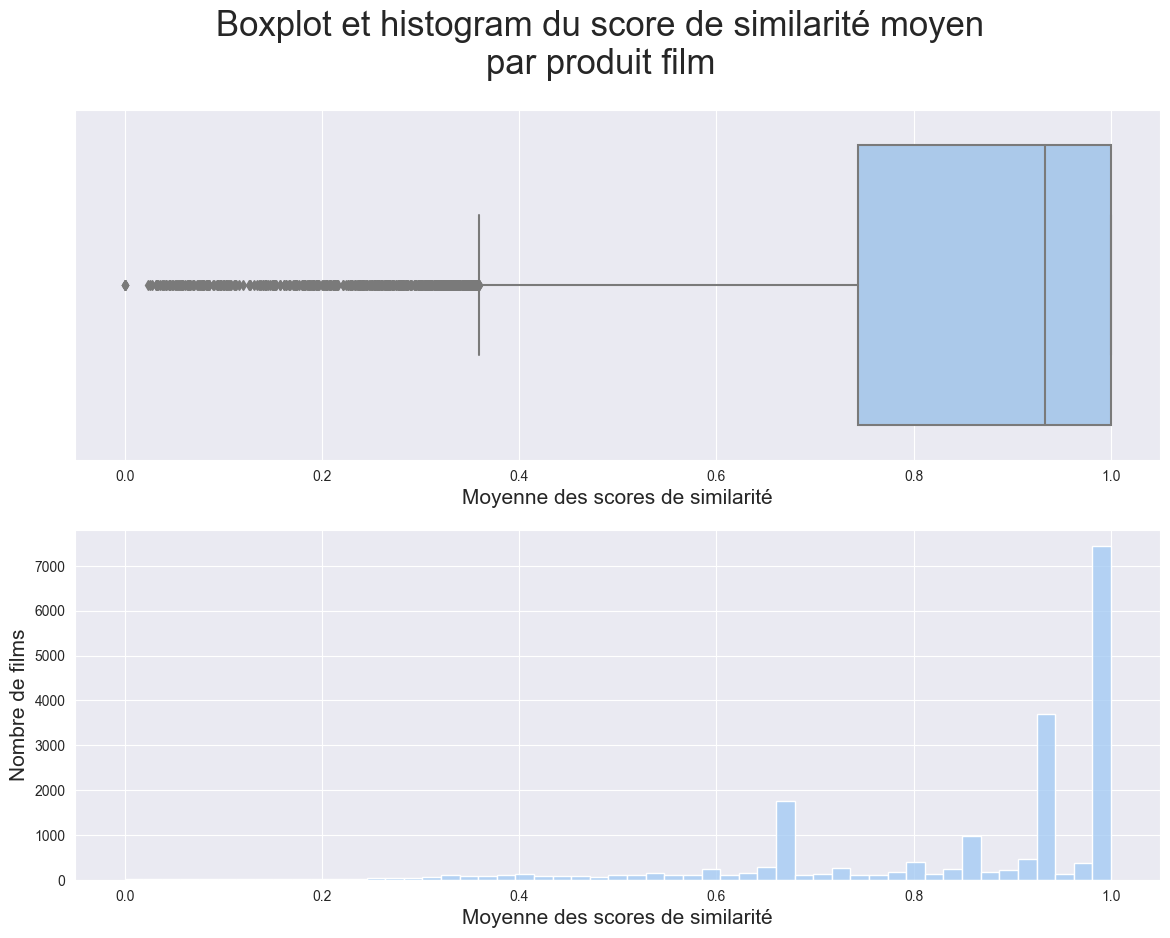

In [136]:
fig, axes = plt.subplots(2,1, figsize=(14,10))

#Nombre d'ingrédients maximum pour un seul produit : 
ax=axes[0]

sns.boxplot(data= df, x="score_mean", ax=ax)
ax.set_xlabel("Moyenne des scores de similarité", fontsize=15)
#ax.set_title("Boxplot du nombre d'ingrédients par produit\n", fontsize=25)


ax=axes[1]
sns.histplot(data=df, x="score_mean",ax=ax)
#ax.set_title("Histogramme du nombre d'ingrédients par produit\n", fontsize=25)
ax.set_xlabel("Moyenne des scores de similarité",fontsize=15)
ax.set_ylabel("Nombre de films", fontsize=15)

#plt.tight_layout()
plt.suptitle("Boxplot et histogram du score de similarité moyen\npar produit film", fontsize=25)
plt.show()

La plupart des films semblent bien avoir été trouvés.

Il y a un pic autour des 0.66 qui arrive sûrement lorsque 2 paramètres sont similaires et 1 ne l'est pas. 

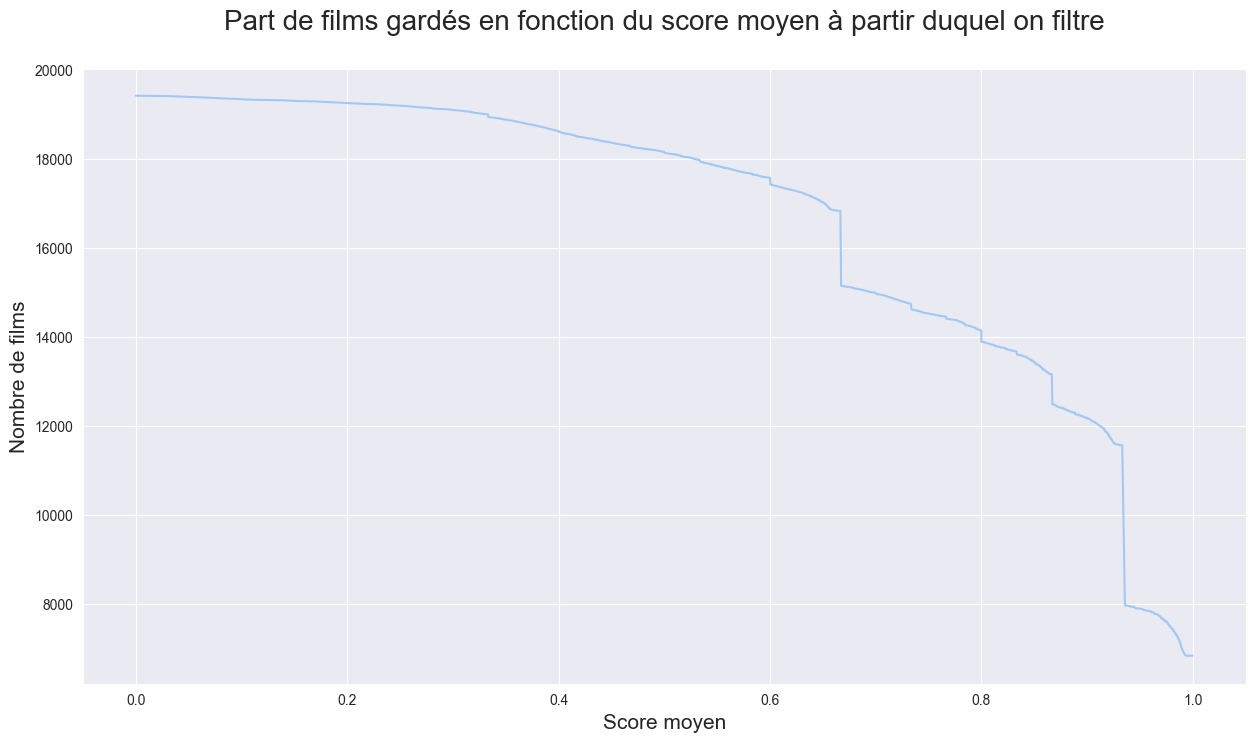

In [137]:
temp = df.groupby("score_mean").agg("count").reset_index().sort_values("score_mean",ascending=False)[["score_mean","id"]]
temp["Somme_cummulee"]= temp["id"].cumsum()

sns.lineplot(data=temp,x="score_mean",y="Somme_cummulee")
plt.xlabel("Score moyen",fontsize=15)
plt.ylabel("Nombre de films",fontsize=15)
plt.title("Part de films gardés en fonction du score moyen à partir duquel on filtre\n",fontsize=20)
plt.show()

In [138]:
seuil = 0.65
print(f"Nombre de films pour un seuil de {seuil} :", len(df[df["score_mean"]>seuil]))

Nombre de films pour un seuil de 0.65 : 17007


On observe qu'en filtrant les films à partir d'un score de similarité moyen de 0.65 on garderait environ 17000 films.

In [139]:
#Filtre : 
df = df[df["score_mean"]>0.65]

In [140]:
check_nan(df)
print()
check_unique(df)
df.shape

Valeurs nan dans id_searched_movie : 0
Valeurs nan dans titre : 0
Valeurs nan dans id : 0
Valeurs nan dans year : 13
Valeurs nan dans actors : 0
Valeurs nan dans score_title : 0
Valeurs nan dans score_year : 0
Valeurs nan dans score_actors : 0
Valeurs nan dans score_mean : 0
Valeurs nan dans href : 0

Valeurs uniques dans id_searched_movie : 17007
Valeurs uniques dans titre : 16365
Valeurs uniques dans id : 16929
Valeurs uniques dans year : 106
Valeurs uniques dans actors : 16261
Valeurs uniques dans score_title : 237
Valeurs uniques dans score_year : 6
Valeurs uniques dans score_actors : 431
Valeurs uniques dans score_mean : 1048
Valeurs uniques dans href : 16966


(17007, 10)

Nous observons qu'il reste en encore des id dupliqués. C'est un problème car cela signifie que l'on a trouvé le même id imdb pour des films sensés être différents sur Allociné.

Pour remédier à cela nous décidons de ne garder à chaque fois que le film avec le score le plus élevé. 

In [141]:
df = df.sort_values("score_mean",ascending=False).drop_duplicates("id",keep='first')

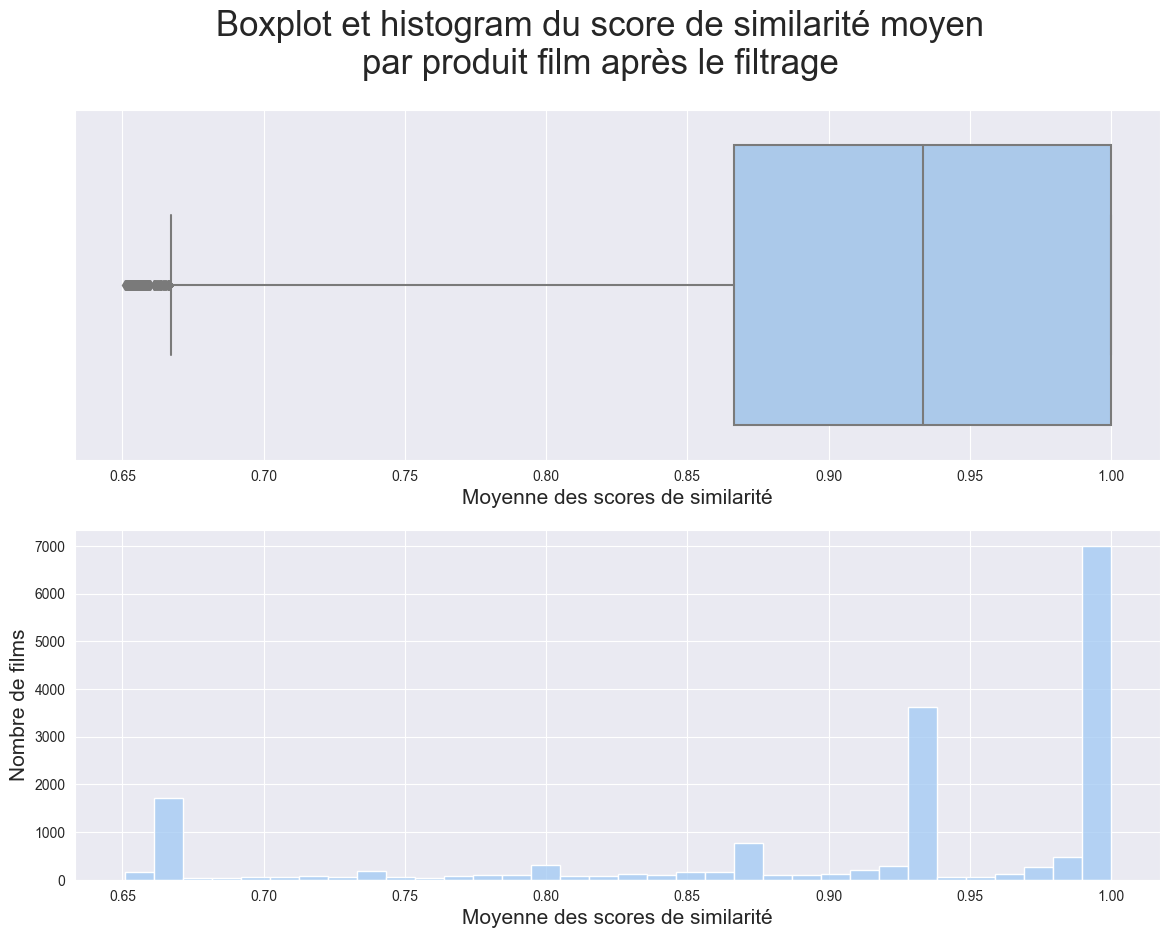

In [142]:
fig, axes = plt.subplots(2,1, figsize=(14,10))

#Nombre d'ingrédients maximum pour un seul produit : 
ax=axes[0]

sns.boxplot(data= df, x="score_mean", ax=ax)
ax.set_xlabel("Moyenne des scores de similarité", fontsize=15)
#ax.set_title("Boxplot du nombre d'ingrédients par produit\n", fontsize=25)


ax=axes[1]
sns.histplot(data=df, x="score_mean",ax=ax)
#ax.set_title("Histogramme du nombre d'ingrédients par produit\n", fontsize=25)
ax.set_xlabel("Moyenne des scores de similarité",fontsize=15)
ax.set_ylabel("Nombre de films", fontsize=15)

#plt.tight_layout()
plt.suptitle("Boxplot et histogram du score de similarité moyen\npar produit film après le filtrage", fontsize=25)
plt.show()

In [143]:
check_nan(df)
print()
check_unique(df)
print("Shape :",df.shape)

Valeurs nan dans id_searched_movie : 0
Valeurs nan dans titre : 0
Valeurs nan dans id : 0
Valeurs nan dans year : 13
Valeurs nan dans actors : 0
Valeurs nan dans score_title : 0
Valeurs nan dans score_year : 0
Valeurs nan dans score_actors : 0
Valeurs nan dans score_mean : 0
Valeurs nan dans href : 0

Valeurs uniques dans id_searched_movie : 16929
Valeurs uniques dans titre : 16365
Valeurs uniques dans id : 16929
Valeurs uniques dans year : 106
Valeurs uniques dans actors : 16261
Valeurs uniques dans score_title : 225
Valeurs uniques dans score_year : 6
Valeurs uniques dans score_actors : 420
Valeurs uniques dans score_mean : 1012
Valeurs uniques dans href : 16929
Shape : (16929, 10)


## Sauvegarde 

In [144]:
df.to_csv(data_path+"IMDB_best_matching_ids_cleaned.csv",index=False)

# Scrapping des données box office : 

## Lecture des données 

In [20]:
df_imdb_ids = pd.read_csv(data_path+"IMDB_best_matching_ids_cleaned.csv")
df_imdb_ids.head()

,id_searched_movie,titre,id,year,actors,score_title,score_year,score_actors,score_mean,href
0,249092,Blame!,tt6574146,2017.0,"['takahiro sakurai', 'kana hanazawa']",1.0,1.0,1.0,1.0,/title/tt6574146/?ref_=fn_tt_tt_1
1,178979,Kick-Ass 2,tt1650554,2013.0,"['aaron taylor-johnson', 'chloë grace moretz']",1.0,1.0,1.0,1.0,/title/tt1650554/?ref_=fn_tt_tt_1
2,129557,Pour elle,tt1217637,2008.0,"['vincent lindon', 'diane kruger']",1.0,1.0,1.0,1.0,/title/tt1217637/?ref_=fn_tt_tt_1
3,36464,Flic Story,tt0072996,1975.0,"['alain delon', 'jean-louis trintignant']",1.0,1.0,1.0,1.0,/title/tt0072996/?ref_=fn_tt_tt_1
4,33913,Dernier domicile connu,tt0064225,1970.0,"['lino ventura', 'marlène jobert']",1.0,1.0,1.0,1.0,/title/tt0064225/?ref_=fn_tt_tt_1


In [21]:
def get_data_box_office(movie_id, movie_href_imdb) :
    data={'movie_id': movie_id, 'href_imdb':movie_href_imdb}

    url =f"https://www.imdb.com{movie_href_imdb}"
    req = Request(
        url=url, 
        headers={'User-Agent': 'Mozilla/5.0'}
    )
    try : 
        webpage = urlopen(req).read()
        soup = BeautifulSoup(webpage, 'html.parser')

        #Budget, revenues, Box office 
        sections = soup.find_all("section",{"data-testid":"BoxOffice"})
        if len(sections)>0 :
            lis = sections[0].find_all("li",{"role": "presentation", "class" : "ipc-metadata-list__item"})
            if len(lis)>0 : 
                for li in lis : 
                    label = li.get("data-testid").split("-")[-1]
                    #label = li.find("button", {"class": "ipc-metadata-list-item__label","role":"button"}).text 
                    value=np.nan
                    text= li.find("label", {"class" : "ipc-metadata-list-item__list-content-item","role":"button"}).text.replace(" ","").replace(",","")
                    match = re.search(r'\d+',text )
                    if match:
                        value = match.group()
                    data[label] = value
            else : 
                print(f"Pas de li dans la section BoxOffice pour {url}")
        else : 
            print(f"Pas de section BoxOffice pour {url}")


        #Pays et langue d'origine  : 
        data["pays_origine"] =[]
        data["langue_origine"]= []

        sections = soup.find_all("section", {"data-testid":"Details"})
        if len(sections)>0 : 

            #Pays d'origine
            try :
                lis_origin= sections[0].find("li",{'data-testid':"title-details-origin"}).find_all("li",{"role":'presentation', "class":"ipc-inline-list__item"})
            except : 
                print(f"li title-details-origin pas trouvée pour {url}")

            if len(lis_origin)>0 :#Au moins un pays trouvé
                for li in lis_origin : 
                    data["pays_origine"].append(li.text)
            else : 
                print(f"Pas de pays d'origine pour {url}")

            #Langue d'origine 
            try : 
                lis_langue = sections[0].find("li",{"data-testid":'title-details-languages'}).find_all("li",{"role":"presentation","class":"ipc-inline-list__item"})
                if len(lis_langue)>0 : 
                    for li in lis_langue : 
                        data["langue_origine"].append(li.text)
                else : 
                    print(f"Pas de langue d'origine pour {url}")
            except : 
                print(f'li title-details-language pas trouvée pour {url}')

        else : 
            print(f"Pas de section details pour {url}")
    except Exception as err : 
        print(f"{url}, erreur : {err}")

    return data

## Proto 

In [22]:
row_processed = df_imdb_ids[df_imdb_ids["id"]=="tt6565702"]#df_imdb_ids.sample()
movie_href_imdb  = row_processed["href"].iloc[0]
movie_id = row_processed["id"].iloc[0]
get_data_box_office(movie_id, movie_href_imdb)

{'movie_id': 'tt6565702',
 'href_imdb': '/title/tt6565702/?ref_=fn_tt_tt_1',
 'budget': '200000000',
 'grossdomestic': '65845974',
 'openingweekenddomestic': '32828348',
 'cumulativeworldwidegross': '252442974',
 'pays_origine': ['United States', 'Canada'],
 'langue_origine': ['English', 'French']}

In [23]:
def workload_threads_box_office(params) : 
    df_to_process = df_imdb_ids[params["index_start"]:params["index_end"]]
    new_data = []
    
    for i in range(len(df_to_process)) : 
        new_data.append(get_data_box_office(df_to_process["id_searched_movie"].iloc[i], df_to_process["href"].iloc[i]))
        if i % 20 == 0 : 
            if params["id"]==0 : 
                clear_output()
            print(f"Threads n°{params['id']} : {i} films sur {len(df_to_process)}")
        time.sleep(random.randint(5,10)/10)
    
    #Sauvegarde des données : 
    df= pd.DataFrame(new_data)
    temp = pd.read_csv(data_path+f"IMDB_box_office/{params['id']}.csv")
    pd.concat([temp,df]).to_csv(data_path+f"IMDB_box_office/{params['id']}.csv",index=False)

In [24]:
def init_save_files_box_office(number) :
    for i in range(number) :
        df_init= pd.DataFrame(columns= ['movie_id','href_imdb', 'pays_origine','langue_origine','budget','grossdomestic','openingweekenddomestic','cumulativeworldwidegross'])
        df_init.to_csv(data_path+f"IMDB_box_office/{i}.csv",index=False)

## Algorithme scrapping des données de budget, revenue et d'origine des films 

12h15

In [25]:
%%time 
nb_threads =5
list_ids =df_imdb_ids["href"].tolist()
nb_movies= len(list_ids)

ids_movies_by_threads = init_movies_by_driver(nb_threads, nb_movies)
init_save_files_box_office(nb_threads)

with futures.ThreadPoolExecutor() as executor: 
    future_results = [ executor.submit(workload_threads_box_office,{'id':i, 'index_start' :ids_movies_by_threads[i]["start"] , 'index_end':ids_movies_by_threads[i]["end"]})  for i in range(nb_threads)] 
    for future_result in future_results: 
        try: 
            future_result = future_result.result()
        except Exception as exc: # can give a exception in some thread, but 
            print("thread generated an exception",exc)
            break;
        
#Concaténation et sauvegarde des données 
df=pd.DataFrame()
for i in range(nb_threads): 
    df=pd.concat([df, pd.read_csv(data_path+f"IMDB_box_office/{i}.csv")])
df.to_csv(data_path+f"IMDB_box_office_langues.csv",index=False) 

Threads n°0 : 3380 films sur 3386
Pas de section BoxOffice pour https://www.imdb.com/title/tt0055602/?ref_=fn_tt_tt_1
Pas de section BoxOffice pour https://www.imdb.com/title/tt3904758/?ref_=fn_tt_tt_17
Pas de section BoxOffice pour https://www.imdb.com/title/tt0021165/?ref_=fn_tt_tt_14
Pas de section BoxOffice pour https://www.imdb.com/title/tt4842646/?ref_=fn_tt_tt_1
Pas de section BoxOffice pour https://www.imdb.com/title/tt0095467/?ref_=fn_tt_tt_1
Threads n°4 : 3380 films sur 3385
Pas de section BoxOffice pour https://www.imdb.com/title/tt0203040/?ref_=fn_tt_tt_16
Threads n°2 : 3380 films sur 3386
Pas de section BoxOffice pour https://www.imdb.com/title/tt15332236/?ref_=fn_tt_tt_2
Pas de section BoxOffice pour https://www.imdb.com/title/tt0060773/?ref_=fn_tt_tt_1
Pas de section BoxOffice pour https://www.imdb.com/title/tt10103028/?ref_=fn_tt_tt_1
Pas de section BoxOffice pour https://www.imdb.com/title/tt5532280/?ref_=fn_tt_tt_1
Pas de section BoxOffice pour https://www.imdb.com/ti

## Lecture des données 

In [27]:
df = pd.read_csv(data_path+f"IMDB_box_office_langues.csv")
print("Shape :",df.shape)
print()
check_nan(df)
print()
check_unique(df)
df.head()

Shape : (16929, 8)

Valeurs nan dans movie_id : 0
Valeurs nan dans href_imdb : 0
Valeurs nan dans pays_origine : 0
Valeurs nan dans langue_origine : 0
Valeurs nan dans budget : 8551
Valeurs nan dans grossdomestic : 8839
Valeurs nan dans openingweekenddomestic : 9512
Valeurs nan dans cumulativeworldwidegross : 4569

Valeurs uniques dans movie_id : 16929
Valeurs uniques dans href_imdb : 16929
Valeurs uniques dans pays_origine : 2182
Valeurs uniques dans langue_origine : 2203
Valeurs uniques dans budget : 1083
Valeurs uniques dans grossdomestic : 8016
Valeurs uniques dans openingweekenddomestic : 7301
Valeurs uniques dans cumulativeworldwidegross : 12311


,movie_id,href_imdb,pays_origine,langue_origine,budget,grossdomestic,openingweekenddomestic,cumulativeworldwidegross
0,249092,/title/tt6574146/?ref_=fn_tt_tt_1,['Japan'],['Japanese'],NaN,NaN,NaN,NaN
1,178979,/title/tt1650554/?ref_=fn_tt_tt_1,"['United Kingdom', 'United States', 'Japan']",['English'],28000000.0,28795985.0,13332955.0,60795985.0
2,129557,/title/tt1217637/?ref_=fn_tt_tt_1,"['France', 'Spain']","['French', 'Spanish']",7930000.0,NaN,NaN,6548942.0
3,36464,/title/tt0072996/?ref_=fn_tt_tt_1,"['France', 'Italy']",['French'],NaN,NaN,NaN,NaN
4,33913,/title/tt0064225/?ref_=fn_tt_tt_1,"['France', 'Italy']",['French'],NaN,NaN,NaN,NaN


Nous observons qu'il y a un nombre conséquentes de films pour lesquels les données sur le boxOffice n'étaient pas disponibles.

## Mise en forme des données

In [32]:
df=df.rename(columns={"grossdomestic":"gross_domestic",
                   "openingweekenddomestic":"opening_weekend_domestic",
                  "cumulativeworldwidegross":"cumulative_world_wide_gross"})
df.head()

,movie_id,href_imdb,pays_origine,langue_origine,budget,gross_domestic,opening_weekend_domestic,cumulative_world_wide_gross
0,249092,/title/tt6574146/?ref_=fn_tt_tt_1,['Japan'],['Japanese'],NaN,NaN,NaN,NaN
1,178979,/title/tt1650554/?ref_=fn_tt_tt_1,"['United Kingdom', 'United States', 'Japan']",['English'],28000000.0,28795985.0,13332955.0,60795985.0
2,129557,/title/tt1217637/?ref_=fn_tt_tt_1,"['France', 'Spain']","['French', 'Spanish']",7930000.0,NaN,NaN,6548942.0
3,36464,/title/tt0072996/?ref_=fn_tt_tt_1,"['France', 'Italy']",['French'],NaN,NaN,NaN,NaN
4,33913,/title/tt0064225/?ref_=fn_tt_tt_1,"['France', 'Italy']",['French'],NaN,NaN,NaN,NaN


## Sauvegarde des données : 

In [33]:
df.to_csv(data_path+f"IMDB_box_office_langues_cleaned.csv")